In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. 

The prediction is scored using RMSE (Root-mean-squared error). Which means we want low values (closer to 0)

As of this edit, my model is placed at rank 93

#### Note to self: Possibly look for more values that don't make sense/skew data (such as moving a distance of 0)

#### Change the following in model: 'objective': 'regression', metric': 'rmse'

# Imports

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [120]:
train = pd.read_csv('train.csv', nrows = 500000)
test = pd.read_csv('test.csv', nrows = 500000)

# Explore/Cleanup/Improve Data

In [121]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
key                  500000 non-null object
fare_amount          500000 non-null float64
pickup_datetime      500000 non-null object
pickup_longitude     500000 non-null float64
pickup_latitude      500000 non-null float64
dropoff_longitude    499995 non-null float64
dropoff_latitude     499995 non-null float64
passenger_count      500000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 30.5+ MB
None


In [122]:
# Not too many null values, let's get rid of them now.

train.dropna(how='any',axis='rows')

print(train.head())

                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3       

It'd be good to add more categories based off the ones we have now to possibly learn even more from the data (like the displacement)

**We'll be adding the following new categories:**

Day (Day of the week)

Month (Month it takes place in)

Year (Year it takes place in)

Hour (Time of day)

DistLat (Distance in latitude)

DistLon (Distance in longitude)

DistTot (Total distance)


In [123]:
# First the dates

train['Day'] = train['pickup_datetime'].str.slice(8,10)
train['Month'] = train['pickup_datetime'].str.slice(5,7)
train['Year'] = train['pickup_datetime'].str.slice(0,4)
train['Hour'] = train['pickup_datetime'].str.slice(11,13)

# Now distance

train['DistLat'] = np.absolute(train['pickup_latitude'] - train['dropoff_latitude'])
train['DistLon'] = np.absolute(train['pickup_longitude'] - train['dropoff_longitude'])

# Yay for distance formula!
train['DistTot'] = np.sqrt(((train['pickup_longitude'] - train['dropoff_longitude'])**2)+
                           ((np.absolute(train['pickup_latitude'] - train['dropoff_latitude'])**2)))

Let's make sure that these new values are all floats and not strings, otherwise our model will complain later on when we try to fit it!

In [124]:
print(train.dtypes)

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
Day                   object
Month                 object
Year                  object
Hour                  object
DistLat              float64
DistLon              float64
DistTot              float64
dtype: object


Looks like we need to convert the new dates we made and passenger_count.

In [125]:
train['passenger_count'] = train['passenger_count'].astype('float')
train['Day'] = train['Day'].astype('float')
train['Month'] = train['Month'].astype('float')
train['Year'] = train['Year'].astype('float')
train['Hour'] = train['Hour'].astype('float')

print(train.dtypes)

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
Day                  float64
Month                float64
Year                 float64
Hour                 float64
DistLat              float64
DistLon              float64
DistTot              float64
dtype: object


Time to do some visualization!

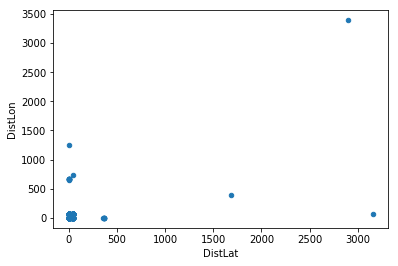

In [126]:
# Scatter plot showing the distance traveled in latitude vs longitude

train.plot.scatter(x='DistLat', y='DistLon')

I don't know about you, but being in a taxi for some of those distances seems strange. Let's look into that more.

According to https://www.walksofnewyork.com/blog/nyc-numbers, New York City is 13.4 miles in length and 2.3 miles in width.

A degree of latitude is about 69 miles apart. A degree of longitude varies (due to the spherical shape of our planet)

**The formula for determining longtitude is as follows:

longtitude = cosine (latitude in decimal degrees) * length of degree (miles) at equator

Our latitudes are almost all at 40.7, meaning we get .75 * 69.172 = 52.44 miles

**So, our conclusion?

If you've traveled more than a degree in longitude or latitude, you've left NYC by quite a bit. So let's drop any row that has a distance traveled of more than 2 degrees in latitude or longtitude

In [127]:
# Values over 100 seem way out of place

tooFar = (train['DistLat'] >= 2) | (train['DistLon'] >= 2)

train.drop(train[tooFar].index, inplace=True)

Let's see how many values we have left.

In [128]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498995 entries, 0 to 499999
Data columns (total 15 columns):
key                  498995 non-null object
fare_amount          498995 non-null float64
pickup_datetime      498995 non-null object
pickup_longitude     498995 non-null float64
pickup_latitude      498995 non-null float64
dropoff_longitude    498990 non-null float64
dropoff_latitude     498990 non-null float64
passenger_count      498995 non-null float64
Day                  498995 non-null float64
Month                498995 non-null float64
Year                 498995 non-null float64
Hour                 498995 non-null float64
DistLat              498990 non-null float64
DistLon              498990 non-null float64
DistTot              498990 non-null float64
dtypes: float64(13), object(2)
memory usage: 60.9+ MB
None


Still plenty of data to work with. Let's look at a correlation map.

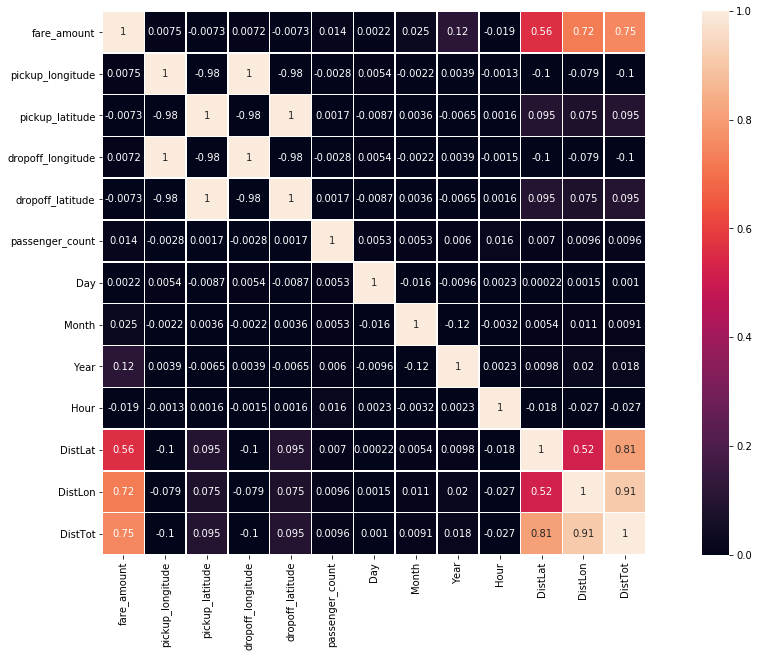

In [129]:
correlations = train.corr()

f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(correlations, vmin=0, vmax=1, annot=True, square=True, linewidths=.5);

The total fare amount does seem to correlate with each distance, which is what we'd expect thankfully. I think we're ready to move onto creating our model.

# Creating/Testing Model

In [130]:
# We want to predict fare amount (y value) by using our predictors (x value)

y = train['fare_amount']

x = train[['DistLon','DistLat','DistTot',
           'Day','Month','Year',
           'Hour','passenger_count','pickup_longitude',
          'pickup_latitude','dropoff_longitude','dropoff_latitude']]

In [131]:
# Split up data to train and test different parts

xTrain, xTest, yTrain, yTest = train_test_split(x,y)

# Create/Fit Model
model = XGBRegressor(n_estimators=300, early_stopping_rounds=5, learning_rate=.1)

model.fit(xTrain, yTrain)

# Predict with model
predictions = model.predict(xTest)

# Test accuracy using the scoring system of Mean Absolute Error
# Differences in MAE vs RMSE can be found here 
# http://www.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm
# It is important to note that mean absolute error will always result in smaller numbers.
# This is because the RMSE gives a relatively high weight to large errors (since you're squaring numbers)


MAE = mean_absolute_error(yTest, predictions)
print("Mean Absolute Error of Model: {}".format(MAE))


Mean Absolute Error of Model: 1.9649363939714468


# Final Model

Time to catch our test dataset up to where our training one is at!

In [132]:
test['Day'] = test['pickup_datetime'].str.slice(8,10)
test['Month'] = test['pickup_datetime'].str.slice(5,7)
test['Year'] = test['pickup_datetime'].str.slice(0,4)
test['Hour'] = test['pickup_datetime'].str.slice(11,13)
test['DistLat'] = np.absolute(test['pickup_latitude'] - test['dropoff_latitude'])
test['DistLon'] = np.absolute(test['pickup_longitude'] - test['dropoff_longitude'])
test['DistTot'] = np.sqrt(((test['pickup_longitude'] - test['dropoff_longitude'])**2)+
                           ((np.absolute(test['pickup_latitude'] - test['dropoff_latitude'])**2)))

test['passenger_count'] = test['passenger_count'].astype('float')
test['Day'] = test['Day'].astype('float')
test['Month'] = test['Month'].astype('float')
test['Year'] = test['Year'].astype('float')
test['Hour'] = test['Hour'].astype('float')

Building Final Model

In [133]:
xFinal = test[['DistLon','DistLat','DistTot',
               'Day','Month','Year',
               'Hour','passenger_count','pickup_longitude',
          'pickup_latitude','dropoff_longitude','dropoff_latitude']]

# Create/Fit Model
model = XGBRegressor(n_estimators=300, early_stopping_rounds=5, learning_rate=.1)

model.fit(x,y)

# Predict with model
predictions = model.predict(xFinal)

# Submission

In [134]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)